## Regime aware factor strategy

Based on the HMM model predictions of bull, bear, and stagnant markets - we will assign allocation to different factors that historically do well in certain regimes - for example, momentum in bull regime and low volatility in bear regime

In [1]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import yfinance as yf
import seaborn as sns
from fredapi import Fred


# Turn off warnings
warnings.filterwarnings("ignore")

### Getting market returns data

In [3]:
# Define ticker and date rangticker = "BSE-500.BO"
start_date = "1980-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

ticker = '^NSEI'
# Download data
data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
data = data[['Close']]
yf_market_data = data['Close'].resample('ME').last()

display(yf_market_data.head())


nifty_historical = pd.read_csv("./data/NIFTY 50_Historical_PRICE.csv")
nifty_historical['Date'] = pd.to_datetime(nifty_historical['Date'])
nifty_historical = nifty_historical.set_index('Date').resample('ME').ffill()
nifty_historical = nifty_historical[:yf_market_data.index[0]-pd.DateOffset(days=15)]

display(nifty_historical.tail())
nifty_historical  = pd.DataFrame(nifty_historical['Close'])
nifty_historical = nifty_historical.rename(columns = {'Close': '^NSEI'})

market_data = pd.concat([nifty_historical, yf_market_data], axis=0)
market_data['Return'] = market_data['^NSEI'].pct_change()
market_data.iloc[5:]

[*********************100%***********************]  1 of 1 completed


Ticker,^NSEI
Date,
2007-09-30,5021.350098
2007-10-31,5900.649902
2007-11-30,5762.750000
2007-12-31,6138.600098
2008-01-31,5137.450195


,Index Name,Open,High,Low,Close
Date,,,,,
2007-04-30,NIFTY 50,4081.60,4096.90,4028.90,4087.90
2007-05-31,NIFTY 50,4250.25,4306.75,4250.25,4295.80
2007-06-30,NIFTY 50,4282.40,4321.35,4280.95,4318.30
2007-07-31,NIFTY 50,4444.25,4534.20,4432.85,4528.85
2007-08-31,NIFTY 50,4412.60,4471.30,4403.00,4464.00


,^NSEI,Return
Date,,
1990-12-31,330.860000,-0.100166
1991-01-31,314.360000,-0.049870
1991-02-28,379.940000,0.208614
1991-03-31,366.450000,-0.035506
1991-04-30,389.010000,0.061564
...,...,...
2025-09-30,24611.099609,0.007543
2025-10-31,25722.099609,0.045142
2025-11-30,26202.949219,0.018694


### Creating an HMM prediction model that updates every month

In [5]:
# Function to train HMM up to a specified end_date
from hmmlearn import hmm
import numpy as np

def train_hmm_until_date(market_data, end_date):
    """
    Trains a 3-regime Categorical HMM on market_data['Return'] up to end_date.
    Args:
        market_data (pd.DataFrame): DataFrame with a 'Return' column and datetime index.
        end_date (str or pd.Timestamp): Last date (inclusive) for training data.
    Returns:
        model: Trained hmm.CategoricalHMM model
        regimes: Array of regime labels for the training period
        returns: Returns used for training
    """
    # Ensure end_date is a Timestamp
    end_date = pd.to_datetime(end_date)
    # Filter returns up to end_date
    returns = market_data.loc[market_data.index <= end_date, "Return"].dropna()
    X_cont = returns.values  # continuous returns (for quantile binning)

    # Use fixed quantile thresholds (can be parameterized)
    q1, q2 = -0.005, 0.005

    def categorize(r):
        if r <= q1:
            return 0  # Bear
        elif r <= q2:
            return 1  # Stagnant
        return 2      # Bull

    regimes = np.array([categorize(r) for r in X_cont])
    X = regimes.reshape(-1, 1)

    model = hmm.CategoricalHMM(
        n_components=3,
        n_iter=100,
        random_state=42,
        init_params="ste",
        verbose=False
    )
    model.fit(X)
    return model, regimes, returns

In [10]:
# Simplified function to classify regimes and return a DataFrame with Date, Returns, and Regime label
def classify_regimes_with_hmm(model, market_data, end_date):
    """
    Uses a trained HMM to classify regimes for returns up to end_date.
    Returns a DataFrame with Date index, Returns, and Regime (Bull, Bear, Stagnant).
    """
    end_date = pd.to_datetime(end_date)
    returns = market_data.loc[market_data.index <= end_date, "Return"].dropna()
    X_cont = returns.values
    q1, q2 = -0.005, 0.005
    def categorize(r):
        if r <= q1:
            return 0  # Bear
        elif r <= q2:
            return 1  # Stagnant
        return 2      # Bull
    regimes = np.array([categorize(r) for r in X_cont])
    X = regimes.reshape(-1, 1)
    hidden_states = model.predict(X)
    # Map hidden states to regime labels based on mean returns
    regime_means = pd.Series(returns.values).groupby(hidden_states).mean()
    sorted_states = regime_means.sort_values().index.tolist()
    state_to_label = {sorted_states[0]: 'Bear', sorted_states[1]: 'Stagnant', sorted_states[2]: 'Bull'}
    regime_labels = [state_to_label[s] for s in hidden_states]
    df = pd.DataFrame({
        'Returns': returns.values,
        'Regime': regime_labels
    }, index=returns.index)
    return df

# Example usage:
# model, _, _ = train_hmm_until_date(market_data, '2022-12-31')
# regime_df = classify_regimes_with_hmm(model, market_data, '2022-12-31')
# regime_df.head()

In [11]:
model, _, _ = train_hmm_until_date(market_data, '2022-12-31')
df = classify_regimes_with_hmm(model, market_data, '2022-12-31')

In [12]:
df

,Returns,Regime
Date,,
1990-08-31,0.151451,Stagnant
1990-09-30,0.099135,Bear
1990-10-31,-0.082007,Stagnant
1990-11-30,-0.089110,Bear
1990-12-31,-0.100166,Stagnant
...,...,...
2022-08-31,0.035030,Stagnant
2022-09-30,-0.037442,Bear
2022-10-31,0.053693,Stagnant


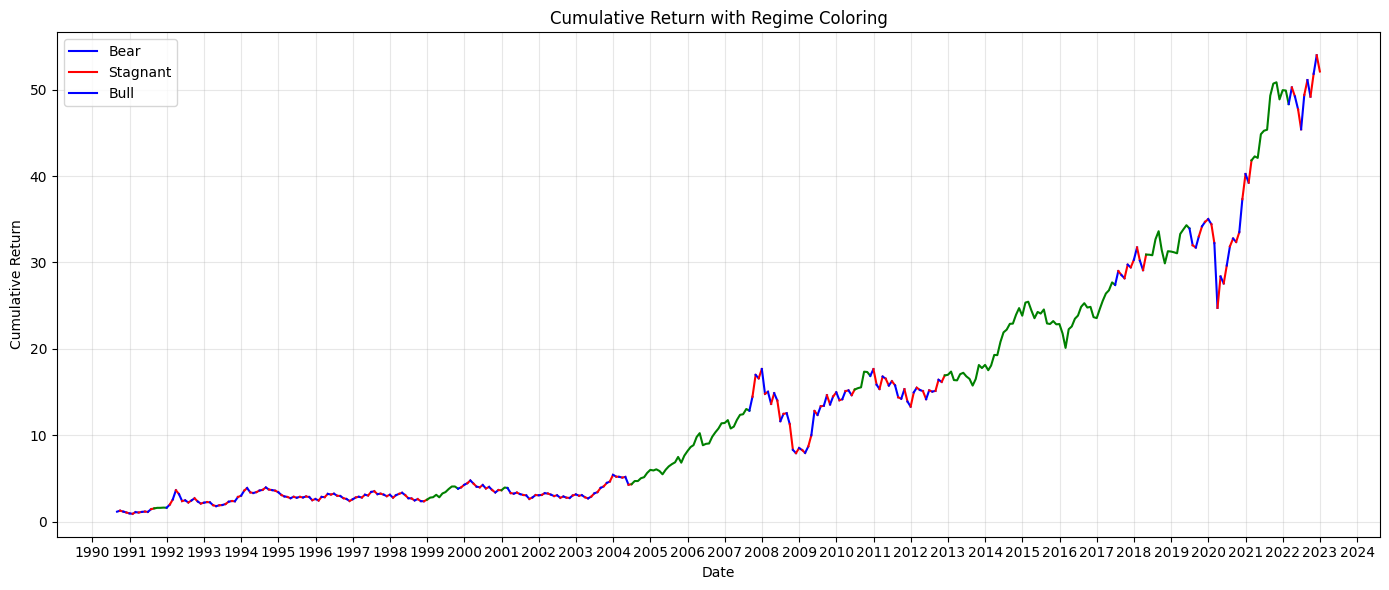

In [13]:
# Plot cumulative returns with regime coloring
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Calculate cumulative returns
cumulative_return = (1 + df['Returns']).cumprod()

# Define regime colors
regime_colors = {'Bear': 'red', 'Stagnant': 'blue', 'Bull': 'green'}

fig, ax = plt.subplots(figsize=(14, 6))

# Plot by regime segments
prev_regime = None
start_idx = None
for i, (date, row) in enumerate(df.iterrows()):
    regime = row['Regime']
    if prev_regime is None:
        prev_regime = regime
        start_idx = i
    elif regime != prev_regime:
        # Plot previous segment
        segment = cumulative_return.iloc[start_idx:i+1]
        ax.plot(segment.index, segment.values, color=regime_colors[prev_regime], label=prev_regime if start_idx == 0 else "")
        prev_regime = regime
        start_idx = i
# Plot last segment
segment = cumulative_return.iloc[start_idx:]
ax.plot(segment.index, segment.values, color=regime_colors[prev_regime], label=prev_regime if start_idx == 0 else "")

# Formatting
ax.set_title('Cumulative Return with Regime Coloring')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend(['Bear', 'Stagnant', 'Bull'])
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [78]:
momentum = pd.read_csv('./data/[ind]_[momentum]_[monthly]_[vw_cap].csv')
value = pd.read_csv('./data/[ind]_[value]_[monthly]_[vw_cap].csv')
data_risk_free = pd.read_csv('./data/indian_risk_free_rate.csv')


In [79]:
data_risk_free# Ensure 'Date' is datetime and set as index for all DataFrames
momentum['date'] = pd.to_datetime(momentum['date'])
value['date'] = pd.to_datetime(value['date'])
data_risk_free['date'] = pd.to_datetime(data_risk_free['date'])

momentum = momentum.set_index('date')
value = value.set_index('date')
data_risk_free = data_risk_free.set_index('date')
# Inner join on Date index
combined_df = momentum.join(value, how='inner', lsuffix='_momentum', rsuffix='_value')
combined_df = combined_df.join(data_risk_free, how='inner')

combined_df['ret_momentum'] = combined_df['ret_momentum'] + combined_df['ret']/12
combined_df['ret_value'] = combined_df['ret_value'] + combined_df['ret']/12

combined_df = combined_df[['ret_momentum', 'ret_value']]

display(combined_df.head())

,ret_momentum,ret_value
date,,
1993-11-30,0.065047,0.009525
1993-12-31,0.006888,0.023006
1994-01-31,-0.011058,-0.015688
1994-02-28,0.043290,0.014648
1994-03-31,0.000423,-0.039308


In [80]:
from fredapi import Fred

fred = Fred(api_key='8b995803b3d5488cc5f5dcaaedb698ff')

series_id = 'DEXINUS'
usd_inr_data = fred.get_series(series_id)

# Step 4: Convert to DataFrame for easier handling
usd_inr_data_df = pd.DataFrame(usd_inr_data, columns=['USDINR=X'])
usd_inr_data_df.index.name = 'Date'
usd_inr_data_df = usd_inr_data_df.resample('ME').last()


ticker = 'USDINR=X'
# Download data
start_date = usd_inr_data_df.index[-1] + MonthEnd(1)
usd_inr = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
usd_inr = usd_inr[['Close']]
usd_inr = usd_inr.resample('ME').last()

usd_inr = pd.concat([usd_inr_data_df,usd_inr['Close']], axis=0)
usd_inr['usd_inr_return'] = usd_inr['USDINR=X'].pct_change()
usd_inr.head()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['USDINR=X']: YFPricesMissingError('possibly delisted; no price data found  (1d 2026-02-28 00:00:00 -> 2026-01-17) (Yahoo error = "Invalid input - start date cannot be after end date. startDate = 1772236800, endDate = 1768608000")')


,USDINR=X,usd_inr_return
Date,,
1973-01-31,8.00,NaN
1973-02-28,7.52,-0.060000
1973-03-31,7.55,0.003989
1973-04-30,7.53,-0.002649
1973-05-31,7.39,-0.018592


In [81]:
usd_inr.tail()

,USDINR=X,usd_inr_return
Date,,
2025-09-30,88.78,0.006804
2025-10-31,88.75,-0.000338
2025-11-30,89.43,0.007662
2025-12-31,89.84,0.004585
2026-01-31,90.16,0.003562


In [82]:
combined_df = combined_df.join(usd_inr, how='inner')

In [83]:
combined_df["ret_momentum"] = ((combined_df["ret_momentum"] + 1) * (combined_df['usd_inr_return'] + 1) - 1)
combined_df["ret_value"] = ((combined_df["ret_value"] + 1) * (combined_df['usd_inr_return'] + 1) - 1)
combined_df.head()

,ret_momentum,ret_value,USDINR=X,usd_inr_return
1993-11-30,0.065386,0.009846,31.44,0.000318
1993-12-31,0.006888,0.023006,31.44,0.000000
1994-01-31,-0.011058,-0.015688,31.44,0.000000
1994-02-28,0.040967,0.012389,31.37,-0.002226
1994-03-31,0.000423,-0.039308,31.37,0.000000


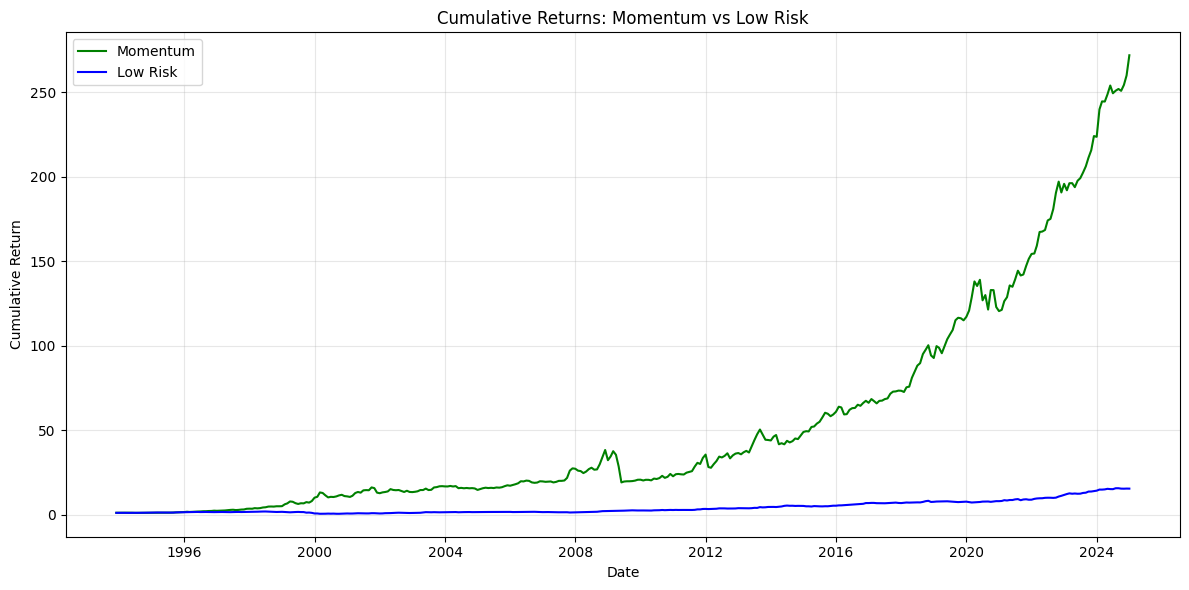

In [84]:
# Plot cumulative returns for ret_momentum and ret_value in one chart
cum_momentum = (1 + combined_df['ret_momentum']).cumprod()
cum_value = (1 + combined_df['ret_value']).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cum_momentum, label='Momentum', color='green')
plt.plot(cum_value, label='Low Risk', color='blue')
plt.title('Cumulative Returns: Momentum vs Low Risk')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Creating a regime aware Low Risk + Momentum Strategy

In [85]:
# Strategy: Regime-aware allocation between momentum and low risk (Jan 2014 onward)

results = []
start_date = pd.to_datetime("2014-01-01")
all_months = combined_df.loc[combined_df.index >= start_date].index

for i in range(len(all_months) - 1):
    train_end = all_months[i]
    next_month = all_months[i + 1]
    
    # Train HMM up to current month
    model, _, _ = train_hmm_until_date(market_data, train_end)
    # Predict regime for current month
    regime_df = classify_regimes_with_hmm(model, market_data, train_end)
    regime = regime_df.iloc[-1]['Regime']
    
    # Choose factor for next month
    if regime == 'Bull':
        chosen_factor = 'momentum'
        ret = combined_df.loc[next_month, 'ret_momentum']
    else:
        chosen_factor = 'value'
        ret = combined_df.loc[next_month, 'ret_value']
    
    results.append({
        'Date': next_month,
        'Return': ret,
        'Regime': regime,
        'Factor': chosen_factor
    })

strategy_df = pd.DataFrame(results).set_index('Date')
display(strategy_df.head())

,Return,Regime,Factor
Date,,,
2014-02-28,-0.015806,Stagnant,value
2014-03-31,0.044655,Stagnant,value
2014-04-30,0.029344,Stagnant,value
2014-05-31,-0.015442,Bull,momentum
2014-06-30,0.049491,Bull,momentum


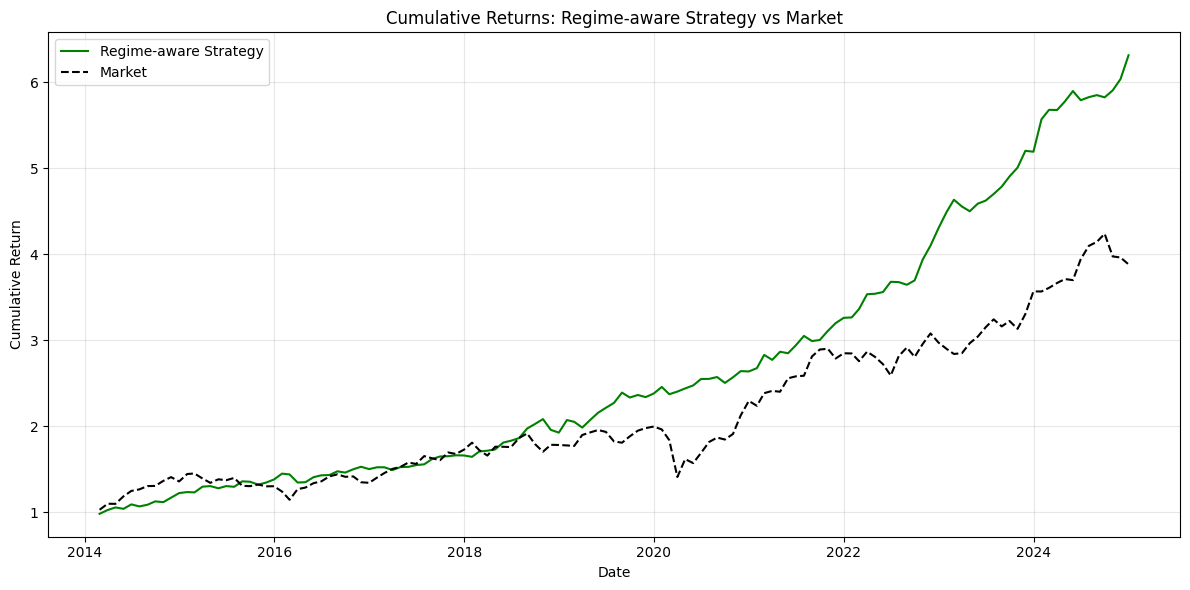

In [89]:
# Plot cumulative returns of the strategy vs market
cumulative_strategy = (1 + strategy_df['Return']).cumprod()
cumulative_market = (1 + market_data['Return'].loc[cumulative_strategy.index]).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy, label='Regime-aware Strategy', color='green')
plt.plot(cumulative_market, label='Market', color='black', linestyle='--')
plt.title('Cumulative Returns: Regime-aware Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [91]:
from scipy.stats import norm

def performance_metrics(returns, risk_free_rate=0.06, periods_per_year=12):
    returns = returns.dropna()
    ann_return = (1 + returns).prod() ** (periods_per_year / len(returns)) - 1
    ann_vol = returns.std() * (periods_per_year ** 0.5)
    sharpe = (ann_return - risk_free_rate) / ann_vol if ann_vol > 0 else np.nan
    # Max drawdown
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_dd = drawdown.min()
    return ann_return, ann_vol, sharpe, max_dd

start = "2014-02-28"
end = "2024-12-31"

# Slice the data
strategy_ret = strategy_df.loc[start:end, "Return"]
momentum_ret = combined_df.loc[start:end, "ret_momentum"]
value_ret = combined_df.loc[start:end, "ret_value"]
market_ret = market_data.loc[start:end, "Return"]

# Calculate metrics
metrics = {}
metrics['Strategy'] = performance_metrics(strategy_ret)
metrics['Momentum'] = performance_metrics(momentum_ret)
metrics['Value'] = performance_metrics(value_ret)
metrics['Market'] = performance_metrics(market_ret)

# Display results
summary = pd.DataFrame(metrics, index=['Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown']).T
display(summary)

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
Strategy,0.183869,0.087175,1.420932,-0.075251
Momentum,0.176397,0.111126,1.047435,-0.133374
Value,0.118433,0.088306,0.661712,-0.124071
Market,0.132318,0.159382,0.453737,-0.293439


In [90]:
strategy_df.tail()

,Return,Regime,Factor
Date,,,
2024-08-31,0.004033,Bull,momentum
2024-09-30,-0.004387,Bull,momentum
2024-10-31,0.013861,Bull,momentum
2024-11-30,0.022184,Bull,momentum
2024-12-31,0.045951,Bull,momentum
